In [1]:
import os
import numpy as np
import pandas as pd

import lightning.pytorch as pl
import torch

from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from tensorboard import program
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, SMAPE #, PoissonLoss

import warnings
warnings.filterwarnings("ignore")

import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/daokedao999/.local/share/jupyter/kernels/myenv


/home/daokedao999/miniconda3/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Create the 'time_idx' column with incremental values from 0 to 99
time_idx = np.arange(100)

# Create the 'values' column with values representing a sine wave
time_points = np.linspace(0, 2, 100)
values = np.sin(time_points)

# Create the 'group_ids' column with a constant value of 66
#group1 = np.full(50, 11)
#group2 = np.full(30, 22)
#group3 = np.full(20, 33)

#group_ids = np.concatenate((group1, group2, group3), axis = 0)

# Combine the columns into a dictionary
data = {'time_idx': time_idx, 'vals': values, 'group_ids': 66}

# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df.head(10))
print(df.shape)
print(df.dtypes)

   time_idx      vals  group_ids
0         0  0.000000         66
1         1  0.020201         66
2         2  0.040393         66
3         3  0.060569         66
4         4  0.080720         66
5         5  0.100838         66
6         6  0.120916         66
7         7  0.140943         66
8         8  0.160914         66
9         9  0.180818         66
(100, 3)
time_idx       int64
vals         float64
group_ids      int64
dtype: object


In [3]:
#data slicing
training_cutoff = 50
train_df = df[lambda x: x.time_idx < training_cutoff]
val_df = df[lambda x: (x.time_idx >= training_cutoff) & (x.time_idx < 80)]
test_df = df[lambda x: x.time_idx >= 80]

print(f"""
train_df shape: {train_df.shape}
val_df shape: {val_df.shape}
test_df shape: {test_df.shape}
""")


train_df shape: (50, 3)
val_df shape: (30, 3)
test_df shape: (20, 3)



In [4]:
print(f"""check any NaN in the data:
        train_df: {train_df.isna().any().any()}
        val_df: {val_df.isna().any().any()}
        test_df: {test_df.isna().any().any()}
        """)

check any NaN in the data:
        train_df: False
        val_df: False
        test_df: False
        


In [5]:
print(f"""any inf in data:
        train_df: {train_df.isin([-np.inf, np.inf]).any().any()}
        val_df: {val_df.isin([-np.inf, np.inf]).any().any()}
        test_df: {test_df.isin([-np.inf, np.inf]).any().any()}
        """)

any inf in data:
        train_df: False
        val_df: False
        test_df: False
        


In [6]:
# Create the TimeSeriesDataSet
train_dataset = TimeSeriesDataSet(
    train_df,
    group_ids=["group_ids"],
    target="vals",
    time_idx="time_idx",
    max_encoder_length = 5,
    max_prediction_length = 2,
    time_varying_unknown_reals=["vals"],
    target_normalizer=EncoderNormalizer(transformation="softplus")
)

In [7]:
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    val_df
)
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df
)

In [ ]:
train_dataloader = train_dataset.to_dataloader(
    train=False, #keep the "train=False" is to sliding through the whole dataset
    batch_size=100 #make the "batch size" >> than the dataset size is to align with the sliding window effect
)
val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=100
)
test_dataloader = test_dataset.to_dataloader(
    train=False,
    batch_size=100
)

In [ ]:
pl.seed_everything(666)

lr_tune_logger = TensorBoardLogger(save_dir = "", version = "lr")  # logging results to the current pwd
lr_early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, mode="min"
)

#set up trainer for tunning
lr_trainer = pl.Trainer(
    accelerator = "gpu",
    devices = "auto",
    gradient_clip_val = 0.1,
    #fast_dev_run=True,  # comment in for debugging, only 1 training and 1 validation batch to run
    callbacks=[lr_early_stop_callback],
    logger = lr_tune_logger #if the logger is not set, the default loger will be saved under default name = version_0
)

#set up tft for tunning 
tft_tuner = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # dummy lr required for the following lr_finder initiation
    learning_rate = 0.06,
    hidden_size = 8,  # most important hyperparameter apart from learning rate
    lstm_layers = 2,  # set to 2 or 3 for large datasets
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size = 2,
    dropout = 0.1,  # between 0.1 and 0.3 are good values
    loss = QuantileLoss(), 
    #quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98] as defined in `pytorch_forecasting.metrics.quantile.QuantileLoss` source code
    reduce_on_plateau_patience = 100
)
print(f"Number of parameters in network: {tft_tuner.size() / 1e3:.3f}k")

Seed set to 666
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 5.267k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]
Learning rate set to 0.012589254117941664
Restoring states from the checkpoint path at /home/daokedao999/.local/share/jupyter/kernels/myenv/.lr_find_491f6971-e3e7-4442-8199-608eec0473b8.ckpt
Restored all states from the checkpoint at /home/daokedao999/.local/share/jupyter/kernels/myenv/.lr_find_491f6971-e3e7-4442-8199-608eec0473b8.ckpt


suggested learning rate: 0.012589254117941664


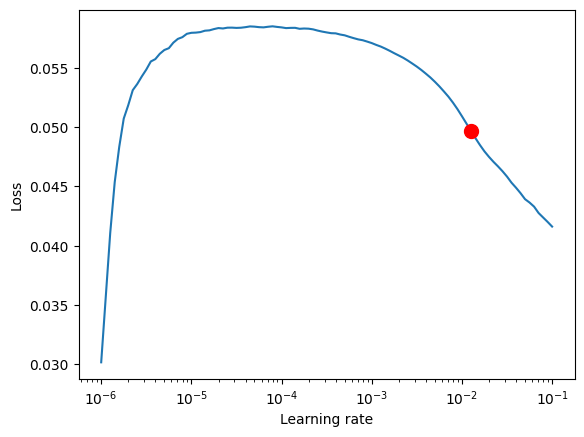

In [10]:
# learning rate optimization
lr_tuner = Tuner(lr_trainer).lr_find(
    tft_tuner,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 0.1,
    min_lr = 1e-6,
)

print(f"suggested learning rate: {lr_tuner.suggestion()}")
fig = lr_tuner.plot(show=True, suggest=True)
fig.show()

In [11]:
#set up trainer for training
logger = TensorBoardLogger(save_dir = "", version = "train")  # logging results to the current pwd
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, mode="min"
)

trainer = pl.Trainer(
    accelerator = "gpu",
    devices = -1,
    gradient_clip_val = 0.1,
    #fast_dev_run=True,  # comment in for debugging, only 1 training and 1 validation batch to run
    callbacks=[early_stop_callback],
    logger = logger,
)

#set up tft for taining
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate = lr_tuner.suggestion(),
    hidden_size = 8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size = 2,
    lstm_layers = 2,  # set to 2 or 3 for large datasets
    dropout = 0.1,  # between 0.1 and 0.3 are good values
    loss = QuantileLoss(),
    reduce_on_plateau_patience = 100
)
print(f"Number of parameters in network: {tft.size() / 1e3:.3f}k") 

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 5.267k


In [12]:
# fit network
trainer.fit(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 320    | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm |

Epoch 34: 100%|██████████| 1/1 [00:01<00:00,  0.68it/s, v_num=rain, train_loss_step=0.0225, val_loss=0.0044, train_loss_epoch=0.0225] 


In [ ]:
#open tensorboard to check the results
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', 'lightning_logs', '--port', '6006'])
print("TensorBoard running at http://localhost:6006/")
tb.main()

In [13]:
#load the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
#check the metrics on val_dataset
trainer.validate(best_tft, dataloaders=val_dataloader)#, ckpt_path=best_model_path)
#the "ckpt_path" argument is not necessary, but it is good practice to load the best model

Restoring states from the checkpoint path at lightning_logs/train/checkpoints/epoch=34-step=35.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs/train/checkpoints/epoch=34-step=35.ckpt


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │     0.008423394523561     │
│         val_MAPE          │   0.008875485509634018    │
│         val_RMSE          │   0.010106625035405159    │
│         val_SMAPE         │   0.008933818899095058    │
│         val_loss          │    0.00440498860552907    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.00440498860552907,
  'val_SMAPE': 0.008933818899095058,
  'val_MAE': 0.008423394523561,
  'val_RMSE': 0.010106625035405159,
  'val_MAPE': 0.008875485509634018}]

In [44]:
test_pred = best_tft.predict(test_dataloader, return_y=True)
test_pred_x = best_tft.predict(test_dataloader, return_x=True)
test_pred_x_raw = best_tft.predict(test_dataloader, mode="raw", return_x=True, return_y=True) #incldue the attension weights

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [45]:
for name, _ in test_pred_x_raw.items():
    print(f"items in `test_pred_x_raw`:{name}")

for name, _ in test_pred_x.items():
    print(f"items in `test_pred_x`:{name}")

for name, _ in test_pred.items():
    print(f"items in `test_pred`:{name}")
    

items in `test_pred_x_raw`:output
items in `test_pred_x_raw`:x
items in `test_pred_x_raw`:index
items in `test_pred_x_raw`:decoder_lengths
items in `test_pred_x_raw`:y
items in `test_pred_x`:output
items in `test_pred_x`:x
items in `test_pred_x`:index
items in `test_pred_x`:decoder_lengths
items in `test_pred_x`:y
items in `test_pred`:output
items in `test_pred`:x
items in `test_pred`:index
items in `test_pred`:decoder_lengths
items in `test_pred`:y


In [ ]:
test_pred_x_raw.plot_prediction(
    test_dataloader,
    idx=0,
    show_future_observed=False,
    add_loss_to_title=True,
    plot_x_quantiles=True,
    plot_y_quantiles=True,
    plot_attentions=True,
    add_encoder_length=True
)

In [ ]:
test_pred_x_raw #the outputs are quantile predictions comparing the single prediction of "test_pred"

Prediction(output=Output(prediction=tensor([[[0.9963, 0.9976, 0.9977, 0.9986, 0.9990, 1.0012, 1.0040],
         [0.9963, 0.9975, 0.9976, 0.9986, 0.9990, 1.0013, 1.0041]],

        [[0.9944, 0.9960, 0.9961, 0.9974, 0.9978, 1.0006, 1.0040],
         [0.9945, 0.9959, 0.9960, 0.9974, 0.9978, 1.0006, 1.0041]],

        [[0.9922, 0.9941, 0.9942, 0.9957, 0.9962, 0.9995, 1.0036],
         [0.9923, 0.9940, 0.9941, 0.9957, 0.9963, 0.9996, 1.0036]],

        [[0.9895, 0.9917, 0.9918, 0.9936, 0.9942, 0.9980, 1.0027],
         [0.9896, 0.9916, 0.9917, 0.9936, 0.9943, 0.9981, 1.0028]],

        [[0.9864, 0.9889, 0.9891, 0.9911, 0.9917, 0.9961, 1.0015],
         [0.9866, 0.9888, 0.9890, 0.9911, 0.9919, 0.9963, 1.0015]],

        [[0.9830, 0.9857, 0.9859, 0.9882, 0.9889, 0.9938, 0.9998],
         [0.9831, 0.9856, 0.9858, 0.9883, 0.9890, 0.9940, 0.9999]],

        [[0.9791, 0.9822, 0.9823, 0.9849, 0.9857, 0.9911, 0.9977],
         [0.9793, 0.9820, 0.9822, 0.9850, 0.9858, 0.9913, 0.9978]],

        [[0.

In [ ]:
test_pred_x_raw.output.prediction.shape #the quantile predictions, the median = test_pred.out

torch.Size([14, 2, 7])

In [22]:
SMAPE()(test_pred.output,test_pred.y)

tensor(0.0252, device='cuda:0')